In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras import Model
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D,
                          Input)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Introduction
This project is on prediction with Natural Language Processing. We will be analysing a dataset comprising of Tweets from the Twitter website and attempting to build a machine learning model to predict which of the Tweets are about a natural disaster and which are not. To do well at this our algorithm will need to be able to detect sentiments and context from the sentences in the tweet. We wil employ a form of Recurrent Neural Network for this task.  

Notebook and code can be found at this Github repo https://github.com/makleks/

## Exploratory Data Analysis
As usual we start by exploring our dataset so we have an idea what we're working with.

In [4]:
# load the training and test data into pandas dataframes
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

View some basic porperties of our dataset.

In [5]:
# print the dimensions of our data
print(train.shape, test.shape)
# print the first 5 rows of data
train.head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's plot a histogram to visualise the distribution of our target variable.

<Axes: >

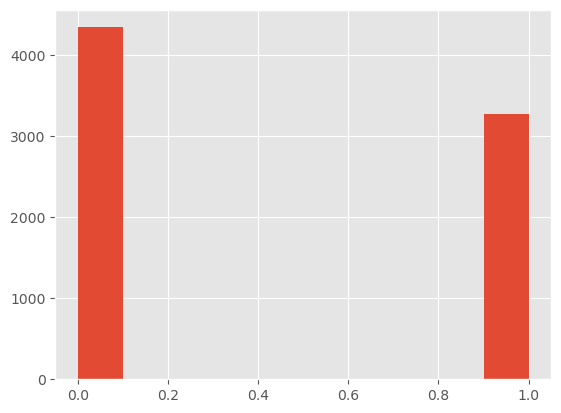

In [6]:
train.target.hist()

We can see from the above that our data is slightly imbalanced. We may have to employ methods to rebalance such as undersampling and oversampling. 

Now let's explore some basic statistics of the text data in our training set. Below we will first check the length of the smallest and largest tweets and then we will also use a histogram to visualise the distribution of tweet length.

In [7]:
print('Longest tweet: ', train['text'].apply(lambda x: len(x.split())).max())
print('Shortest tweet: ', train['text'].apply(lambda x: len(x.split())).min())
print('Average length of tweet: ', train['text'].apply(lambda x: len(x.split())).mean())

Longest tweet:  31
Shortest tweet:  1
Average length of tweet:  14.903585971364771


<Axes: >

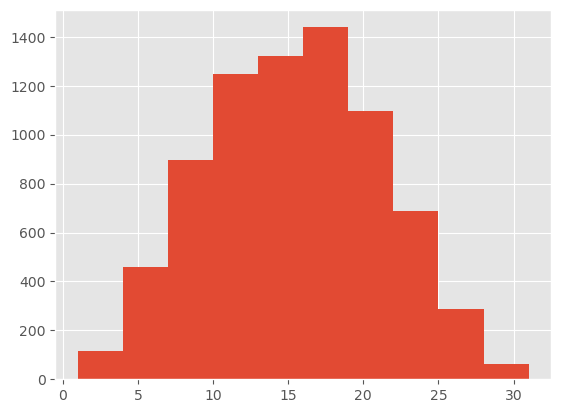

In [8]:
# Histogram showing distribution of Tweet length
train['text'].apply(lambda x: len(x.split())).hist()

In [9]:
train_1 = train.text.values
test_1 = test.text.values
sentiments = train.target.values

## Pre-Processing
Let's carry out some data pre-processing to convert our tweet text data into a form suitable for our machine learning algorithm. 
We first use the Tokenizer() to split our Tweets into Tokens which are basically words

In [10]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_1)

# Calculate the total number of unique words in our dataset 
# which is effectively the size of our voabulary 

vocab_length = len(word_tokenizer.word_index) + 1

Create internal vocabulary and convert each text to a sequence of integers.

In [11]:
tr_val = word_tokenizer.texts_to_sequences(train_1)
te_val = word_tokenizer.texts_to_sequences(test_1)

Our data will need some padding to ensure each entry has the same length. This ensures each input is of an identical size and shape to feed into our neural network. In this instance we choose to use 'post' padding type which means the padding is added to the end of each input.

In [12]:
length_val=max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

## LSTM Model
We will make use of a bi-directional Long-Short Term Memory model to train and fit our text-based data. This model is an improvement on the vanilla Recurrent Neural Network models designed to mitigate the common problems of vanishing gradients and exploding gradients. It does this by using a what is termed a forget gate to keep track of values from previous time intervals. The amount of information to be retained is determined with the use of inptu and output gates.

Specifically we will be using a bidirectional LSTM which allows our model to pass information in both directions to the output layers.

In [13]:
# Define our Bi-Directional LSTM
model = Sequential()
model.add(Embedding(vocab_length, 32, input_length=length_val))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units = 16)))
model.add(Dense(16, activation='tanh'))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

We will be using the Adamax optimizer and a Binary Cross Enthropy loss function for our model.

In [14]:
optimizer = Adamax(
    lr=0.005, 
    decay=0.0005, 
    clipvalue=10
)
loss = BinaryCrossentropy(label_smoothing=0.01)

Now we compile our model specifying the optimzer, loss function and evaluation metric.

In [15]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 32)            726432    
                                                                 
 dropout (Dropout)           (None, 33, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6272      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                        

In the below cell we train our model on our data which has been split into a training and validation set. 

In [16]:
train, test = train_test_split(tr_val, test_size=0.2, random_state=25)
y_train, y_test = train_test_split(sentiments, test_size=0.2, random_state=25)

In [17]:
history = model.fit(
    x = train, 
    y = y_train,
    validation_data = (test, y_test),
    epochs = 10,
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/10
64/64 [==============================] - 8s 46ms/step - loss: 0.6469 - accuracy: 0.6246 - val_loss: 0.5725 - val_accuracy: 0.7163
Epoch 2/10
64/64 [==============================] - 2s 29ms/step - loss: 0.5014 - accuracy: 0.7737 - val_loss: 0.4804 - val_accuracy: 0.7879
Epoch 3/10
64/64 [==============================] - 2s 29ms/step - loss: 0.4270 - accuracy: 0.8135 - val_loss: 0.4604 - val_accuracy: 0.7873
Epoch 4/10
64/64 [==============================] - 2s 29ms/step - loss: 0.3765 - accuracy: 0.8498 - val_loss: 0.4518 - val_accuracy: 0.8037
Epoch 5/10
64/64 [==============================] - 2s 33ms/step - loss: 0.3462 - accuracy: 0.8644 - val_loss: 0.4609 - val_accuracy: 0.8017
Epoch 6/10
64/64 [==============================] - 2s 29ms/step - loss: 0.3188 - accuracy: 0.8816 - val_loss: 0.4756 - val_accuracy: 0.8043
Epoch 7/10
64/64 [==============================] - 2s 28ms/step - loss: 0.2948 - accuracy: 0.8893 - val_loss: 0.4930 - val_accuracy: 0.7971
Epoch 8/10
64

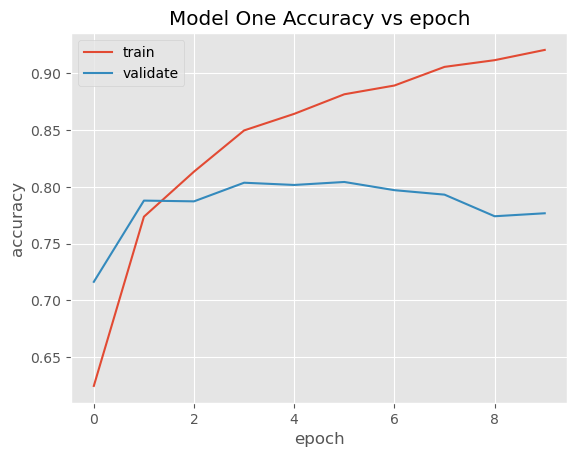

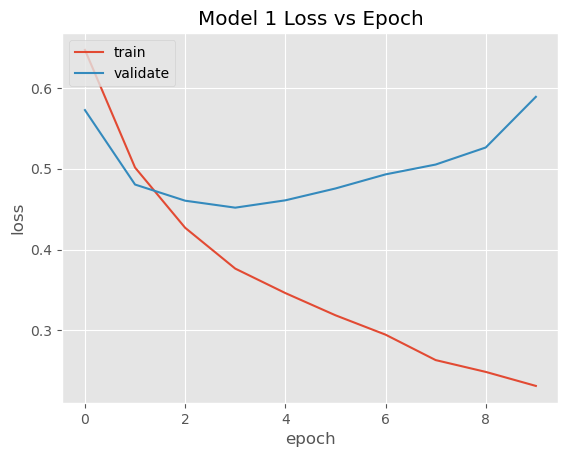

In [18]:
# plot model accuracy per epoch 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Vanilla LSTM Model
We will use thesame parameters with a vanilla LSTM model to compare the performance. Our second model below is identical to the first with the Bi-Directional layer omitted. We will observce what effect if any this has on our model performance.

In [19]:
# Define our Bi-Directional LSTM
model2 = Sequential()
model2.add(Embedding(vocab_length, 32, input_length=length_val))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='tanh'))

model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [20]:
model2.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 32)            726432    
                                                                 
 dropout_2 (Dropout)         (None, 33, 32)            0         
                                                                 
 dense_2 (Dense)             (None, 33, 16)            528       
                                                                 
 dropout_3 (Dropout)         (None, 33, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 528)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 529       
                                                                 
Total params: 727,489
Trainable params: 727,489
Non-tr

In [21]:
history2 = model2.fit(
    x = train, 
    y = y_train,
    validation_data = (test, y_test),
    epochs = 10,
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/10
64/64 [==============================] - 2s 14ms/step - loss: 0.6771 - accuracy: 0.5719 - val_loss: 0.6685 - val_accuracy: 0.5640
Epoch 2/10
64/64 [==============================] - 1s 9ms/step - loss: 0.6395 - accuracy: 0.6429 - val_loss: 0.6191 - val_accuracy: 0.6848
Epoch 3/10
64/64 [==============================] - 1s 9ms/step - loss: 0.5709 - accuracy: 0.7204 - val_loss: 0.5535 - val_accuracy: 0.7334
Epoch 4/10
64/64 [==============================] - 1s 9ms/step - loss: 0.5021 - accuracy: 0.7703 - val_loss: 0.5092 - val_accuracy: 0.7708
Epoch 5/10
64/64 [==============================] - 1s 9ms/step - loss: 0.4450 - accuracy: 0.8100 - val_loss: 0.4902 - val_accuracy: 0.7761
Epoch 6/10
64/64 [==============================] - 1s 9ms/step - loss: 0.4119 - accuracy: 0.8223 - val_loss: 0.4757 - val_accuracy: 0.7879
Epoch 7/10
64/64 [==============================] - 1s 9ms/step - loss: 0.3756 - accuracy: 0.8494 - val_loss: 0.4735 - val_accuracy: 0.7899
Epoch 8/10
64/64 [=

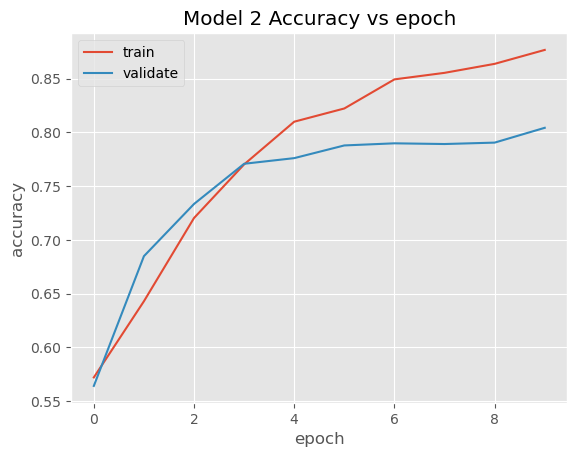

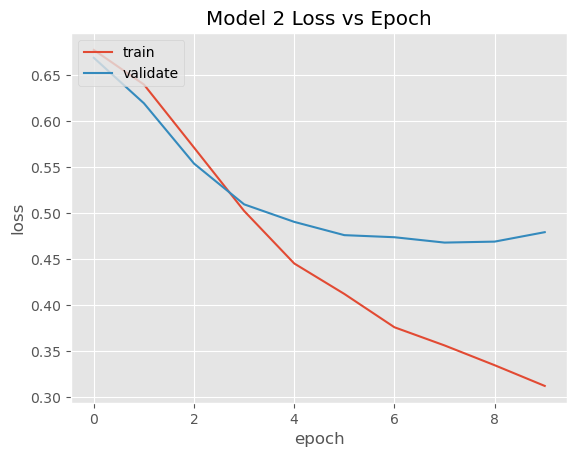

In [22]:
# plot model accuracy per epoch 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Results

Our results show an accuracy of around 81%  on our validation data with either model. The vanilla LSTM model however performs very slightly better than the Bi-Directional LSTM although the BiDi-LSTM converges much faster. We will likely need a larger dataset to see sustained improvement on our metrics. Perhaps a use of augmnetation methods will also have an effect on performance by extending our dataset. 

## Conclusion
We conclude from our observation that BiDiLSTM are relatively effective at the task of sentiment or context prediction at Natural Language Processing task. Even with minimal pre-processing and hyper-parameter tuning we were able to obtain a very decent result. The choice of padding method did not have a huge impact on the results in this task. It is worth carrying out further hyper-parameter tuning to optimise the model performance. Also, it may be worth exploring if we can get access to a larger dataset as the current data is very limited in size especially compared to other NLP applications. Finally, it is always a good idea to check the performance of a pre-trained model at this task as may be give a superior performance after minimal tuning. 

#### Submission Files


In [37]:
predictions = model.predict(te_val)

102/102 [==============================] - 1s 6ms/step


In [40]:
submission['target'] = predictions

In [42]:
submission.to_csv('submissions.csv')